In [ ]:
import os, time, pickle
import pandas as pd
import numpy as np

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch import autocast

from torchinfo import summary

import torchvision.transforms as transforms

from MetaFormerModel.MetaFG_meta import MetaFG_meta_2

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

import matplotlib.pyplot as plt



In [23]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)


Python version
3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
Version info.
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


# parameters

In [2]:
################## Settings #############################
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = True

################## Data Paths ##########################
MODEL_DIR = "./metaformer2_CE_4_DA/"

TRAIN_DATA_DIR = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/SnakeCLEF2023_train-large_size/" # train imgs. path on DGX1
VAL_DATA_DIR = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/SnakeCLEF2023_val-large_size/" # val imgs. path on DGX1

TRAINDATA_CONFIG = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/SnakeCLEF2023-TrainMetadata-iNat.csv"
MISSING_FILES = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/missing_train_data.csv"

VALIDDATA_CONFIG = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/SnakeCLEF2023-ValMetadata.csv"
CCM = "/raid/SnakeCLEF/snakeclef2023/SnakeCLEF2023/computed/CodeSnakeDistributionTrainObservationLevelBin.csv"

NUM_CLASSES = 1784

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
################## Hyperparameters ########################
BATCH_SIZE = 16
NUM_EPOCHS = 30
IMAGE_SIZE = 384

LEARNING_RATE = 1e-05

######## Embedding Token Mappings ########################
CODE_TOKENS = pickle.load(open("meta_code_tokens.p", "rb"))
ENDEMIC_TOKENS = pickle.load(open("meta_endemic_tokens.p", "rb"))

########## Warmup #################
WARMUP = 3

### dataset & loaders

In [3]:
class SnakeTrainDataset(Dataset):
    def __init__(self, data, ccm, transform=None):
        self.data = data
        self.transform = transform # Image augmentation pipeline
        self.code_class_mapping = ccm
        self.code_tokens = CODE_TOKENS
        self.endemic_tokens = ENDEMIC_TOKENS

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        obj = self.data.iloc[index] # get instance
        label = obj.class_id # get label
        code = obj.code if obj.code in self.code_tokens.keys() else "unknown"
        endemic = obj.endemic if obj.endemic in self.endemic_tokens.keys() else "unknown" # get endemic metadata
                
        img = Image.open(obj.image_path).convert("RGB") # load image
        ccm = torch.tensor(self.code_class_mapping[code].to_numpy()) # code class mapping
        meta = torch.tensor([self.code_tokens[code], self.endemic_tokens[endemic]]).float() # metadata tokens

        # img. augmentation
        if self.transform is not None:
            img = self.transform(img)

        return (img, label, ccm, meta)


# valid data preprocessing pipeline
def get_val_preprocessing():
    return transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])



def get_train_augmentation_preprocessing():
    return transforms.Compose([
        transforms.Resize((int(IMAGE_SIZE + IMAGE_SIZE * 0.1), int(IMAGE_SIZE + IMAGE_SIZE * 0.1))),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.GaussianBlur(kernel_size=3),

        
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])




# compute data weights
#def compute_weights(dataset):
#    CLASS_IDS, CLASS_COUNTS = np.unique(dataset['class_id'], return_counts=True)
#    CLASS_WEIGHTS = 1 - (1 / np.sqrt(np.max(CLASS_COUNTS)/CLASS_COUNTS + 0.5))
#    return CLASS_WEIGHTS


def get_datasets():
    # load CSVs
    nan_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
    train_data = pd.read_csv(TRAINDATA_CONFIG, na_values=nan_values, keep_default_na=False)
    missing_train_data = pd.read_csv(MISSING_FILES, na_values=nan_values, keep_default_na=False)
    valid_data = pd.read_csv(VALIDDATA_CONFIG, na_values=nan_values, keep_default_na=False)
    
    # delete missing files of train data table
    train_data = pd.merge(train_data, missing_train_data, how='outer', indicator=True)
    train_data = train_data.loc[train_data._merge == 'left_only', ["observation_id","endemic","binomial_name","code","image_path","class_id","subset"]]               
                                                               
    # load transposed version of CCM table
    ccm = pd.read_csv(CCM, index_col=0, na_values=nan_values, keep_default_na=False).T

    # limit data size
    #train_data = train_data.head(1000)
    #valid_data = valid_data.head(1000)
    print(f'train data shape: {train_data.shape}')

    # add image path
    train_data["image_path"] = TRAIN_DATA_DIR + train_data['image_path']
    valid_data["image_path"] = VAL_DATA_DIR + valid_data['image_path']

    # shuffle
    train_data = train_data.sample(frac=1, random_state=1).reset_index(drop=True)
    valid_data = valid_data.sample(frac=1, random_state=1).reset_index(drop=True)

    # compute train, valid data weights
    #TCLASS_WEIGHTS = compute_weights(train_data)
    #VCLASS_WEIGHTS = compute_weights(valid_data)

    # get train, valid augmentation & preprocessing pipelines
    train_aug_preprocessing = get_train_augmentation_preprocessing()
    val_preprocessing = get_val_preprocessing()

    # create datasets
    train_dataset = SnakeTrainDataset(train_data, ccm, transform=train_aug_preprocessing)
    valid_dataset = SnakeTrainDataset(valid_data, ccm, transform=val_preprocessing)

    return train_dataset, valid_dataset#, TCLASS_WEIGHTS, VCLASS_WEIGHTS


def plot_history(logs):
    fig, ax = plt.subplots(3, 1, figsize=(8, 12))

    ax[0].plot(logs['loss'], label="train data")
    ax[0].plot(logs['val_loss'], label="valid data")
    ax[0].legend(loc="best")
    ax[0].set_ylabel("loss")
    ax[0].set_ylim([0, -np.log(1/NUM_CLASSES)])
    #ax[0].set_xlabel("epochs")
    ax[0].set_title("train- vs. valid loss")

    ax[1].plot(logs['acc'], label="train data")
    ax[1].plot(logs['val_acc'], label="valid data")
    ax[1].legend(loc="best")
    ax[1].set_ylabel("accuracy")
    ax[1].set_ylim([0, 1.01])
    #ax[1].set_xlabel("epochs")
    ax[1].set_title("train- vs. valid accuracy")

    ax[2].plot(logs['f1'], label="train data")
    ax[2].plot(logs['val_f1'], label="valid data")
    ax[2].legend(loc="best")
    ax[2].set_ylabel("f1")
    ax[2].set_ylim([0, 1.01])
    ax[2].set_xlabel("epochs")
    ax[2].set_title("train- vs. valid f1")

    fig.savefig(f'{MODEL_DIR}model_history.svg', dpi=150, format="svg")
    plt.show()

### model

In [4]:
# instantiate the model load checkpoints and move it to the right device
model = MetaFG_meta_2(img_size=IMAGE_SIZE, num_classes=NUM_CLASSES, meta_dims=[1,1])

# load checkpoints
checkpoints = './MetaFormerModel/metafg_2_inat21_384.pth'
pretrained_dict = torch.load(checkpoints, map_location='cpu')

# get init model params
model_dict = model.state_dict()

# filter unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}
model_dict.update(pretrained_dict) 

# load checkpoints to model
model.load_state_dict(model_dict)

device = torch.device(f'cuda:0')
torch.cuda.set_device(device)
model.to(device)

/home/mohammadreza.bagherifar/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


MetaFG_Meta(
  (meta_1_head_1): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): ResNormLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (norm_fn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm_fn2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (w1): Linear(in_features=512, out_features=512, bias=True)
      (w2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (meta_1_head_2): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (3): ResNormLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (norm_fn1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm_fn2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
 

In [5]:
x = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
meta = torch.randn(BATCH_SIZE,2)
print(summary(model, input_data={'x': x, 'meta': meta}, depth=5, device=device))
print(model)

Layer (type:depth-idx)                        Output Shape              Param #
MetaFG_Meta                                   [16, 1784]                1,536
├─Sequential: 1-1                             [16, 512]                 --
│    └─Linear: 2-1                            [16, 512]                 1,024
│    └─ReLU: 2-2                              [16, 512]                 --
│    └─LayerNorm: 2-3                         [16, 512]                 1,024
│    └─ResNormLayer: 2-4                      [16, 512]                 --
│    │    └─Linear: 3-1                       [16, 512]                 262,656
│    │    └─ReLU: 3-2                         [16, 512]                 --
│    │    └─LayerNorm: 3-3                    [16, 512]                 1,024
│    │    └─Linear: 3-4                       [16, 512]                 262,656
│    │    └─ReLU: 3-5                         [16, 512]                 --
│    │    └─LayerNorm: 3-6                    [16, 512]                 1

### train

In [6]:
def warmup(model):
    for i, (param_name, param) in enumerate(model.named_parameters()):
        param.requires_grad = False
    
    for i, (param_name, param) in enumerate(model.meta_1_head_1.named_parameters()):
        param.requires_grad = True
        
    for i, (param_name, param) in enumerate(model.meta_1_head_2.named_parameters()):
        param.requires_grad = True
    
    for i, (param_name, param) in enumerate(model.meta_2_head_1.named_parameters()):
        param.requires_grad = True
        
    for i, (param_name, param) in enumerate(model.meta_2_head_2.named_parameters()):
        param.requires_grad = True
        
    for i, (param_name, param) in enumerate(model.head.named_parameters()):
        param.requires_grad = True
    
    
def warmup_end(model):
    for i, (param_name, param) in enumerate(model.named_parameters()):
        param.requires_grad = True
    

In [7]:
train_dataset, valid_dataset = get_datasets()

# prepare the datasets
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=8, drop_last=False, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=8, drop_last=False, pin_memory=True)


# Optimizer & Schedules & early stopping
#optimizer = torch.optim.Adam([{'params': model.conv_backbone.parameters(), 'lr': LEARNING_RATE},
#                            {'params': model.embedding_loss.parameters(), 'lr': LEARNING_RATE*10},
#                            {'params': model.endemic_embedding.parameters(), 'lr': LEARNING_RATE * 10},
#                            {'params': model.code_embedding.parameters(), 'lr': LEARNING_RATE * 10},
#                            {'params': model.embedding_net.parameters(), 'lr': LEARNING_RATE * 10}
#                            ])

# Optimizer & Schedules & early stopping
#optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
warmup(model)
optimizer = torch.optim.AdamW([{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': LEARNING_RATE*10}])
scaler = GradScaler()

# loss function
loss_fn = nn.CrossEntropyLoss()

# running metrics during training
loss_metric = MeanMetric().to(device)

acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES, average='macro').to(device)
f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(device)
f1country_metric = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(device)

# start time of trainig
start_training = time.perf_counter()
# create log dict
logs = {'loss': [], 'acc': [], 'f1': [], 'f1country': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_f1country': [], 'learning_rate': []}

train data shape: (154216, 7)


In [8]:
# # start a new wandb run to track this script
# wandb.init(
#     entity="snakeclef2023_fhdo", # our team at wandb

#     # set the wandb project where this run will be logged
#     project="meta_former", # -> define sub-projects here, e.g. experiments with MetaFormer or CNNs...
    
#     # define a name for this run
#     name="MetaFormer2_init_run",

#     # track all the used hyperparameters here, config is just a dict object so any key:value pairs are possible
#     config={
#         "learning_rate": LEARNING_RATE,
#         "architecture": "MetaFormer2",
#         "pretrained": "iNat21",
#         "dataset": "snakeclef2023, additional training data not used...",
#         "epochs": NUM_EPOCHS,
#         "img_size": IMAGE_SIZE,
#         "batch_size": BATCH_SIZE,
#         "code_tokens": CODE_TOKENS,
#         "endemic_tokens": ENDEMIC_TOKENS,
#         "embedding_warmup_epochs": WARMUP
#         # ... any other hyperparameter that is necessary to reproduce the result
#     },
    
#     #save_code=True, # save the script file as backup
    
#     dir=MODEL_DIR # locally folder where wandb log files are saved 
# )
  
# # (optional) wandb can also track the model parameters
# # wandb.watch(model)

Epoch 1/30
--> Warm Up 1/3
loss: 3.68721, acc: 0.15132, f1: 0.16464, f1country: 0.27423 - val_loss: 2.23551, val_acc: 0.30490, val_f1: 0.28204, val_f1country: 0.37183 - lr: 0.0001 - epoch runtime: 1837.043 sec.
Epoch 2/30
--> Warm Up 2/3
loss: 2.24467, acc: 0.34171, f1: 0.36726, f1country: 0.48193 - val_loss: 1.79860, val_acc: 0.39284, val_f1: 0.36949, val_f1country: 0.44726 - lr: 0.0001 - epoch runtime: 1833.855 sec.
Epoch 3/30
--> Warm Up 3/3
loss: 1.91914, acc: 0.43333, f1: 0.46518, f1country: 0.56347 - val_loss: 1.67436, val_acc: 0.42206, val_f1: 0.39862, val_f1country: 0.47025 - lr: 0.0001 - epoch runtime: 1834.709 sec.
Epoch 4/30
loss: 1.28502, acc: 0.59641, f1: 0.63146, f1country: 0.69853 - val_loss: 1.28911, val_acc: 0.49782, val_f1: 0.47709, val_f1country: 0.52494 - lr: 1e-05 - epoch runtime: 3741.572 sec.
Epoch 5/30
loss: 0.96625, acc: 0.67740, f1: 0.71329, f1country: 0.75593 - val_loss: 1.16129, val_acc: 0.52263, val_f1: 0.50292, val_f1country: 0.53940 - lr: 1e-05 - epoch ru

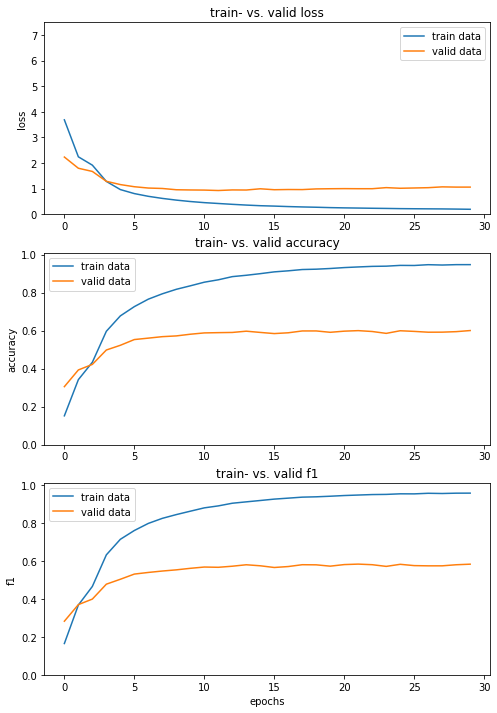

Training succeeded in 105675.724s


In [9]:
#iterate over epochs
for epoch in range(NUM_EPOCHS):
    # start time of epoch
    epoch_start = time.perf_counter()
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    ######################## toggle warmup ########################################
    if (epoch) == WARMUP:
        warmup_end(model)
        optimizer = torch.optim.AdamW([{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': LEARNING_RATE}])
    elif (epoch) < WARMUP:
        print(f'--> Warm Up {epoch+1}/{WARMUP}')

    ############################## train phase ####################################
    model.train()

    # iterate over training batches
    for (inputs, labels, ccm, meta) in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        ccm = ccm.to(device, non_blocking=True)
        meta = meta.to(device, non_blocking=True)
        
        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward with mixed precision
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(x=inputs, meta=meta)
            loss = loss_fn(outputs, labels)

        # backward + optimize with gradient clipping to 1 with mixed precision
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # Compute metrics
        preds = outputs.softmax(dim=-1)
        loss_metric.update(loss)
        acc_metric.update(preds, labels)
        f1_metric.update(preds, labels)
        f1country_metric.update(preds * ccm, labels)

    # compute, sync & reset metrics for validation
    epoch_loss = loss_metric.compute()
    epoch_acc = acc_metric.compute()
    epoch_f1 = f1_metric.compute()
    epoch_f1country = f1country_metric.compute()
    loss_metric.reset()
    acc_metric.reset()
    f1_metric.reset()
    f1country_metric.reset()

    # Append metric results to logs
    logs['loss'].append(epoch_loss.detach().cpu().item())
    logs['acc'].append(epoch_acc.detach().cpu().item())
    logs['f1'].append(epoch_f1.detach().cpu().item())
    logs['f1country'].append(epoch_f1country.detach().cpu().item())
    print(f"loss: {logs['loss'][epoch]:.5f}, acc: {logs['acc'][epoch]:.5f}, f1: {logs['f1'][epoch]:.5f}, f1country: {logs['f1country'][epoch]:.5f}", end=' - ')


    ############################## valid phase ####################################
    with torch.no_grad():
        model.eval()

        # iterate over validation batches
        for (inputs, labels, ccm, meta) in valid_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            ccm = ccm.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)

            # forward with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x=inputs, meta=meta)
                loss = loss_fn(outputs, labels)

            # Compute metrics
            val_preds = outputs.softmax(dim=-1)
            loss_metric.update(loss)
            acc_metric.update(val_preds, labels)
            f1_metric.update(val_preds, labels)
            f1country_metric.update(val_preds * ccm, labels)

        # compute, sync & reset metrics for validation
        epoch_val_loss = loss_metric.compute()
        epoch_val_acc = acc_metric.compute()
        epoch_val_f1 = f1_metric.compute()
        epoch_val_f1country = f1country_metric.compute()
        loss_metric.reset()
        acc_metric.reset()
        f1_metric.reset()
        f1country_metric.reset()

        # get epoch learning rate
        epoch_lr = optimizer.param_groups[0]['lr']

    # Append lr, metric results to logs
    logs['learning_rate'].append(epoch_lr if isinstance(epoch_lr, float) else epoch_lr.detach().cpu().item())
    logs['val_loss'].append(epoch_val_loss.detach().cpu().item())
    logs['val_acc'].append(epoch_val_acc.detach().cpu().item())
    logs['val_f1'].append(epoch_val_f1.detach().cpu().item())
    logs['val_f1country'].append(epoch_val_f1country.detach().cpu().item())
    print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_acc: {logs['val_acc'][epoch]:.5f}, val_f1: {logs['val_f1'][epoch]:.5f}, val_f1country: {logs['val_f1country'][epoch]:.5f} - lr: {epoch_lr}", end=' - ')

    # save logs as csv
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')
    
    # save logs to wandb for this epoch
    # wandb.log(
    #     {k:v[epoch] for k,v in logs.items()}, # e.g. log each metric value for the current epoch in our defined logs dict
    #     step=epoch # epoch index for wandb
    # )

    #save trained model for each epoch
    torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
    torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')

    # end time of epoch
    epoch_end = time.perf_counter()
    print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")

plot_history(logs)
# end time of trainig
end_training = time.perf_counter()
print(f'Training succeeded in {(end_training - start_training):5.3f}s')

# [optional] finish the wandb run, necessary in notebooks
# wandb.finish()